In [174]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

from functions import labelNet, MyDataset, train

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EMOBANK MODELS

In [175]:
eb = pd.read_csv("../../data/clean/emobank_affectivetext_lex.csv")

# Ekman classes
classes = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]
features = ["VADER_neg", "VADER_neu", "VADER_pos", "VADER_compound"\
    , "TextBlob_polarity", "TextBlob_subjectivity", "AFINN"]
# features = ["VADER_neg", "VADER_neu", "VADER_pos", "VADER_compound"]
# features = ["VADER_compound", "TextBlob_polarity", "TextBlob_subjectivity", "AFINN"]
# features = ["V", "A", "D"]
print("Number of features: ", len(features))
print("Number of classes: ", len(classes))

# Split into train, test, dev
eb_train = eb[eb["split"] == "train"]
eb_test = eb[eb["split"] == "test"]
eb_dev = eb[eb["split"] == "dev"]

# Create datasets
train_dataset = MyDataset(eb_train[features+classes], features, classes)
test_dataset = MyDataset(eb_test[features+classes], features, classes)
dev_dataset = MyDataset(eb_dev[features+classes], features, classes)

Number of features:  7
Number of classes:  6


In [176]:
model = labelNet(len(features), 20, len(classes), num_hidden=1)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=1000, shuffle=True)
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

model, train_loss, val_loss = train(model, train_loader, dev_loader, lr=5*1e-4\
                                    , epochs=1000)

Feature batch shape: torch.Size([200, 7])
Labels batch shape: torch.Size([200, 6])
Epoch: 100, Train Loss: 0.0087, Valid loss: 0.0138, Valid class acc: 0.4825
Epoch: 200, Train Loss: 0.0087, Valid loss: 0.0138, Valid class acc: 0.4825
Epoch: 300, Train Loss: 0.0087, Valid loss: 0.0137, Valid class acc: 0.5088
Epoch: 400, Train Loss: 0.0086, Valid loss: 0.0137, Valid class acc: 0.4912
Epoch: 500, Train Loss: 0.0087, Valid loss: 0.0137, Valid class acc: 0.4912
Epoch: 600, Train Loss: 0.0086, Valid loss: 0.0137, Valid class acc: 0.5000
Epoch: 700, Train Loss: 0.0086, Valid loss: 0.0137, Valid class acc: 0.4912
Epoch: 800, Train Loss: 0.0086, Valid loss: 0.0137, Valid class acc: 0.4912
Epoch: 900, Train Loss: 0.0086, Valid loss: 0.0137, Valid class acc: 0.4912
Epoch: 1000, Train Loss: 0.0086, Valid loss: 0.0137, Valid class acc: 0.4912


In [177]:
# classification accuracy on test set
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)
correct, total = 0, 0
with torch.no_grad():
    for features, labels in test_loader:
        outputs = torch.argmax(model(features), dim=-1)
        labels = torch.argmax(labels, dim=-1)
        correct += torch.sum(outputs == labels)
        total += len(labels)

print(f"Test set accuracy: {correct/total:.3f}")

Test set accuracy: 0.435


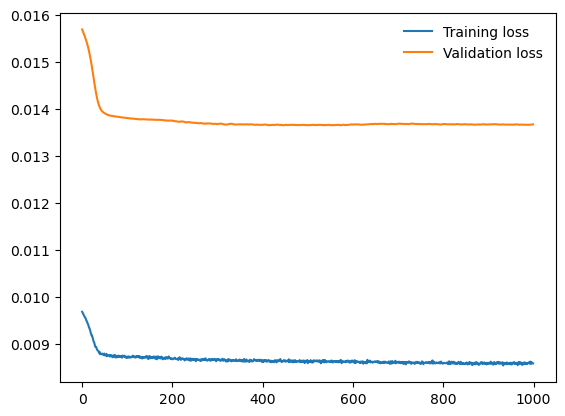

In [178]:
# plot training and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend(frameon=False)
plt.show()

## Add pseudo labels to datasets

In [179]:
def add_label(model, df, features, name="label", save=False, save_path=None):
    """Add label predictions to dataframe"""
    df = df.copy()
    with torch.no_grad():
        inputs = torch.tensor(df[features].values, dtype=torch.float)
        labels = model(inputs)
        labels = torch.argmax(labels, dim=-1)
        df[name] = labels
    if save and save_path:
        df.to_csv(save_path, index=False)
    return df

In [180]:
features = ["VADER_neg", "VADER_neu", "VADER_pos", "VADER_compound"\
    , "TextBlob_polarity", "TextBlob_subjectivity", "AFINN"]
# features = ["V", "A", "D"]

# re-label the full emobank dataset
eb_full = pd.read_csv("../../data/clean/emobank_relabelled.csv", )
add_label(model, eb_full, features, name="map_from_lex"\
    , save=True, save_path="../../data/clean/emobank_relabelled.csv")

# re-label the children's high agreement dataset
ch = pd.read_csv("../../data/clean/children_highAgree.csv")

# re-label the children's high agreement dataset
ch = pd.read_csv("../../data/clean/children_highAgree.csv")